In [1]:
import os
from sklearn.utils import shuffle
import tensorflow as tf
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt
import re
from nltk.translate.bleu_score import corpus_bleu
import pathlib
import pandas as pd
import pickle
from model_utils import *

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
# Load the 4 lists containing image names and captions for both training and validation sets
img_name_train, train_captions, img_name_val, val_captions = load_flickr30k()

Number of distinct images in training set: 29783
Number of distinct images in validation set: 2000
Length of (img_name_train, train_captions): (148915, 148915)
Length of (img_name_val, val_captions): (10000, 10000)


In [4]:
# find the max length of any caption in our dataset
def calc_max_length(tensor):
    """returns length of the lognest tensor"""
    return max(len(t) for t in tensor)

In [5]:
# choose the top 5000 words from the vocabulary
top_k = 8000

# load tokenizer fit on train_captions and preprocessed according to pretrained word vector
with open("tokenizer-8k-vocab.pkl", 'rb') as file:
    tokenizer = pickle.load(file)

# convert train captions to tokenized sequences
train_seqs = tokenizer.texts_to_sequences(train_captions) # output shape = (number_of_captions, None)

# pad each vector to max_length of the captions
cap_train = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post') # shape = (number_of_captions, max_length)

# get the max length of the sequences
max_length = calc_max_length(train_seqs)



In [6]:
# Repeat the tokenization for validation set
# convert val captions to tokenized sequences
val_seqs = tokenizer.texts_to_sequences(val_captions) # output shape = (number_of_captions, None)

# pad each vector to max_length of the captions
cap_val = tf.keras.preprocessing.sequence.pad_sequences(val_seqs, padding='post', maxlen=max_length) # shape = (number_of_captions, max_length)

In [7]:
 cap_train.shape ,cap_val.shape

((148915, 80), (10000, 80))

### Create tf.data input pipeline

In [8]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
embedding_dim = 303
units = 512
vocab_size = top_k # + 1
num_steps = len(img_name_train) // BATCH_SIZE

# Variables representing vector shape extracting from Inception-V3 - (64, 2048)
features_shape = 2048
attention_features_shape = 64

In [9]:
# load the image features from numpy files
def map_func(img_name, cap):
    """takes full image path, caption as input and returns image feature tensor and caption"""
    # change parent directory to the one with saved image features
    img_name = img_name.decode('utf-8')
    img_name = img_name.replace('/flickr30k-images/', '/Image_Features/')
    # load the saved feature array
    img_tensor = np.load(img_name+'.npy')
    return img_tensor, cap


In [10]:
# create Dataset object
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Model

In [11]:
# class to pass extracted images thru a fully connected network
class CNN_Encoder(tf.keras.Model):
    """Passes the InceptionV3 image features through a fully connected layer with `embedding_dim` units"""
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # define fully connected layer
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x    


In [12]:
class BahdanauAttention(tf.keras.Model):
    """Class to implement attention mechanism"""
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        # fc layer for image features
        self.W1 = tf.keras.layers.Dense(units)
        # fc layer for previous hidden state of RNN
        self.W2 = tf.keras.layers.Dense(units)
        # fc layer to get attention coeffients per 2D space of the image
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        """Inputs:
            features shape: (?, 64, embedding_dim)
            hidden shape: (?, units)
        Outputs:
            context_vector shape: (?, embedding_dim)
            attention_weights: (?, 64, 1)
        """
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        # hidden shape: (?, units)
        # hidden_with_time_axis shape: (?, 1, units)

        # combine feature activations with hidden state activations
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        # score shape: (?, 64, units)

        # get the attention weights(coefficients/importance) in the 2D space
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        # attention_weights shape: (?, 64, 1)

        # get the attention weighted image features
        context_vector = attention_weights * features
        # context_vector shape: (?, 64, embedding_dim)

        # consolidate all the activations in the 2D space as one number representing each feature
        context_vector = tf.reduce_sum(context_vector, axis=1)
        # context_vector shape:(?, embedding_dim)

        return context_vector, attention_weights

In [13]:
class RNN_Decoder(tf.keras.Model):
    """Implements RNN for predicting the next word in the sequence"""
    def __init__(self, embedding_dim, units, vocab_size, embedding_matix):
        super(RNN_Decoder, self).__init__()
        self.units = units
        # for getting embedding vector of last word generated
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matix], trainable=False)
        # GRU for processing context_vector after attention
        self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')

        # fc layers after gru
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        # attention object to get context_vector
        self.attention = BahdanauAttention(self.units)

    def __call__(self, x, features, hidden):
        """Inputs:
            x: integer representing last predicted word
            x shape: (?, 1)

            features: image features after passing through encoder
            features shape: (?, 64, embedding_dim)

            hidden: stored last hidden state of GRU
            hidden shape: (?, units)
        Outputs:
            x: prediction for the next word
            x shape: (?, vocab_size)

            state: hidden state of gru
            state shape: (?, units)

            attention_weights shape: (?, 64, 1)
        """
        # get the context vector using attention
        context_vector, attention_weights = self.attention(features, hidden)
        # context_vector shape: (?, embedding_dim)
        
        # get embedding vector of last word in the sequence
        x = self.embedding(x)
        # X shape: (?, 1, embedding_dim)

        # concat last word embedding with the context vector
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # pass the concatenated vector thru gru
        output, state = self.gru(x)
        # output shape:(?, 1, units)
        # state shape: (?, units)

        x = self.fc1(output)
        # x shape: (?, 1, units)

        # remove the extra dimension
        x = tf.reshape(x, (-1, x.shape[2]))
        # x shape: (?, units)

        x = self.fc2(x)
        # x shape: (?, vocab_size)

        return x, state, attention_weights
    
    #reset hidden state to be run before executing a new batch
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))


In [14]:
# load the weights for embedding layer
with open('embedding_matix.pkl', 'rb') as file:
    embedding_matix = pickle.load(file)

In [15]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size, embedding_matix)

In [16]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
 
# define custom loss function to ignore padding
def loss_function(real, pred):
    """applies mask over <pad> token and returns loss"""
    # mask returns True for non-zero integers
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    # apply mask over the losses calculated
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

#### Checkpoint

In [17]:
checkpoint_path = "./checkpoints/train"
# checkpoint on the encoder, decoder and optimizer
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=40)

In [18]:
# use this to see the watched variables
# [var.name for var in tape.watched_variables()]

In [19]:
@tf.function
def train_step(img_tensor, target):
    """function that trains and fits for one batch
    inputs:
        img_tensor shape: (?, 64, 2048)
        target shape: (?, max_length)
    outputs:
        loss: per sample total sequence loss
        total_loss: loss per prediction
    """
    loss = 0

    # initializing the hidden state for each batch because the captions are not related from batch to batch
    hidden = decoder.reset_state(batch_size=target.shape[0])
    # hidden shape: (?, units)

    # define decoder input as the <start> token
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    # dec_input shape: (?, 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        # features shape: (?, 64, embedding_dim)

        # iterate over sequence length and predict one word at a time
        for i in range(1, target.shape[1]):
            # pass the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            # predictions shape: (?, vocab_size)
            # hidden shape: (?, units)

            # loss is per sample total sequence loss
            loss += loss_function(target[:, i], predictions)

            # using teacher forcing for next word prediction
            dec_input = tf.expand_dims(target[:, i], 1)
            # dec_input shape: (?, 1)

    # total_loss is loss per sample per token (or loss per prediction)
    total_loss = (loss / int(target.shape[1]))

    # get a list of all trainable variables
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    # get the repective gradients
    gradients = tape.gradient(loss, trainable_variables)

    # use Adam optimizer to update the variables
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

### Validation Data Pipeline 

In [20]:
# Start the validation code

# load the image features from numpy files
def map_func2(img_name):
    """takes full image path as input and returns image feature tensor"""
    # change parent directory to the one with saved image features
    img_name = img_name.decode('utf-8')
    img_name = img_name.replace('/flickr30k-images/', '/Image_Features/')
    # load the saved feature array
    img_tensor = np.load(img_name+'.npy')
    return img_tensor

In [21]:
# remove the period(.) in the captions
temp_cap = [cap.replace(' .', '') for cap in val_captions]
val_captions = temp_cap

In [22]:
# Prepare Image to References dictionary
img_to_refs = dict()
# iterate over image path and corresponding captions
for img, ref in zip(img_name_val, val_captions):
    if img not in img_to_refs:
        img_to_refs[img] = list()
    img_to_refs[img].append(ref)

# extract the image ids from img_to_refs dictionary
image_ids = list(img_to_refs.keys())
# extract the corresponding list of references per image id
references = list(img_to_refs.values())


In [23]:
image_ids[2], references[2]

('/home/shailesh/Projects/mytf2/Flickr30k_notebooks/Dataset/Flickr30k/flickr30k-images/102575576.jpg',
 ['<start> A couple in their wedding attire stand behind a table with a wedding cake and flowers <end>',
  '<start> A bride and groom are standing in front of their wedding cake at their reception <end>',
  '<start> A bride and groom smile as they view their wedding cake at the reception <end>',
  '<start> A couple stands behind their wedding cake <end>',
  '<start> Man and woman cutting wedding cake <end>'])

In [24]:
# Define Validate Dataset Parameters
VAL_BATCH_SIZE = 64
val_num_steps = len(image_ids) // BATCH_SIZE


In [25]:
# Create the validation set pipeline
val_dataset = tf.data.Dataset.from_tensor_slices(image_ids)

# load image features
val_dataset = val_dataset.map(lambda item1: tf.numpy_function(map_func2, [item1], [tf.float32]), num_parallel_calls = tf.data.experimental.AUTOTUNE)

# convert into batches and prefetch for performance
val_dataset = val_dataset.batch(VAL_BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# val_dataset shape = (?, 64, 2048)

In [26]:
@tf.function
def prediction_step(img_tensor):
    """Function to make predictions for a batch
    Inputs:
        img_tensor shape: (?, 64, 2048)
    """
    prediction_seq = tf.zeros((img_tensor.shape[0], max_length), dtype=tf.int32)
    # prediction_seq = (?, max_length)
    
    # reset hidden state of decoder GRU
    hidden = decoder.reset_state(batch_size=img_tensor.shape[0])
    # hidden shape: (?, units)

    # set up the decoder input as the '<start>' token
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']]*img_tensor.shape[0], 1)
    # dec_input shape: (?, 1)

    # take transpose of prediction_seq so taht ith index is word word for entire batch
    prediction_seq = tf.transpose(prediction_seq)
    # prediction_seq shape: (max_length, ?)

    updates = tf.squeeze(dec_input, axis=1)
    # updates shape: (?,)

    # save the first token in prediction_seq as <start> token
    prediction_seq = tf.tensor_scatter_nd_update(prediction_seq, [[0]], [updates])
    # predicted_seq shape: (max_length, ?)

    # start forward pass
    features = encoder(img_tensor)
    # features shape: (?, 64, embedding_dim)

    for i in range(1, max_length):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        # predictions shape: (?, vocab_size)
        # hidden shape: (?, units)

        # set the predicted token as the decoder input for next iteration
        dec_input = tf.random.categorical(predictions, 1)
        # predicted_id shape(?, 1)

        updates = tf.squeeze(dec_input, axis=1)

        # store the predicted token in the prediction_seq
        prediction_seq = tf.tensor_scatter_nd_update(prediction_seq, [[i]], [updates])

    # take transpose again to revert effect for transpose applied before
    prediction_seq = tf.transpose(prediction_seq)
    # prediction_seq shape: (?, max_length)
    return prediction_seq


In [27]:
#######################################

In [28]:
history_file = pathlib.Path('./History/history.csv')

# create the history file if it doesnt exist
if not history_file.exists():
    # create the history.csv to store training history 
    columns = ['epoch', 'bleu_1', 'bleu_2', 'bleu_3', 'bleu_4', 'training_loss']
    history = pd.DataFrame(columns = columns)
    history.to_csv(path_or_buf=history_file, index=False)

# read the history file
history = pd.read_csv(filepath_or_buffer=history_file)

In [29]:
EPOCHS = 50

# check for saved checkpoints to resume training from ther(
start_epoch = 0
# check if checkpoint is available
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restore the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Restored from {}".format(ckpt_manager.latest_checkpoint))
else:
    print("Initializing training from scratch.")

for epoch in range(start_epoch, EPOCHS):
    # start the clock to record training time
    start = time.time()
    total_loss = 0

    # iterate over batches
    for (batch, (img_tensor, target)) in enumerate(dataset):
        # run train_step for this batch
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        ######################################### Remove this START
        # Printt results per 100 batch runs
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch+1, batch, (batch_loss.numpy() / int(target.shape[1])) ))
        ########################################## END

    # calculate the epoch loss
    training_loss = total_loss.numpy()/num_steps

    # Training code ends here

    # Validation code starts here
    val_start = time.time()
    # create list to store al  predicted captions
    prediction_list = list()
    # iterate over batches
    for batch_num, (img_tensor,) in enumerate(val_dataset):
        prediction_seq = prediction_step(img_tensor)
        
        # create list to store predicted captions in the batch
        prediction_batch = tokenizer.sequences_to_texts(prediction_seq.numpy().tolist())

        # iterate over the predictions and remove the text after <end>
        for i in range(len(prediction_batch)):
            prediction_batch[i] = re.sub(r'<end>.*', '<end>', prediction_batch[i])

        # add the batch predictions in the main prediction_list
        prediction_list += prediction_batch

    # calculate the Bleu Score
    bleu_1, bleu_2, bleu_3, bleu_4 = (corpus_bleu(references, prediction_list, weights=(1, 0, 0, 0)),
                                      corpus_bleu(references, prediction_list, weights=(0.5, 0.5, 0, 0)),
                                      corpus_bleu(references, prediction_list, weights=(1/3., 1/3., 1/3., 0)),
                                      corpus_bleu(references, prediction_list, weights=(1, 1, 1, 1))) 

    # Validation code ends here

    # save the model after every epoch
    if (epoch+1) % 1 == 0:
        save_path = ckpt_manager.save(checkpoint_number=epoch + 1)

    # save the history of this epoch
    history = history.append({'epoch':epoch+1, 
                            'bleu_1': bleu_1, 
                            'bleu_2' : bleu_2, 
                            'bleu_3': bleu_3, 
                            'bleu_4' :bleu_4, 
                            'training_loss': training_loss}, 
                        ignore_index=True)
    history.to_csv(path_or_buf=history_file, index=False)

    print('Epoch:{} Training_Loss:{:.6f} BLEU-1:{:.6f}, BLEU-2:{:.6f}, BLEU-3:{:.6f}, BLEU-4:{:.6f}\n'.format(epoch + 1, training_loss,bleu_1,bleu_2,bleu_3,bleu_4))
    print("Time taken for {}th epoch {} sec\n".format(epoch+1, time.time()- start))

Restored from ./checkpoints/train/ckpt-50


In [35]:
# 1 epoch with validation takes 25 mins

In [31]:
history
# 29, 47, 49 seem promising

,epoch,bleu_1,bleu_2,bleu_3,bleu_4,training_loss
0,1.0,0.841779,0.741731,0.617150,0.069949,0.601750
1,2.0,0.856265,0.755017,0.628705,0.075739,0.529784
2,3.0,0.849398,0.749683,0.625774,0.075103,0.504394
3,4.0,0.831358,0.736952,0.618113,0.072556,0.485689
4,5.0,0.863261,0.764623,0.642057,0.085368,0.470337
5,6.0,0.851689,0.753997,0.632399,0.079337,0.457363
6,7.0,0.860492,0.760301,0.637839,0.082754,0.445295
7,8.0,0.837429,0.742253,0.622930,0.075403,0.435087
8,9.0,0.826316,0.732522,0.614385,0.071039,0.425644
9,10.0,0.849258,0.752474,0.632183,0.080576,0.417764


No handles with labels found to put in legend.


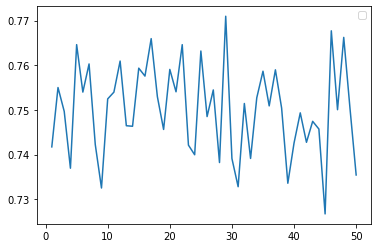

In [32]:
import matplotlib.pyplot as plt


# plt.plot(history.epoch, history.bleu_1)
plt.plot(history.epoch, history.bleu_2)
# plt.plot(history.epoch, history.bleu_3)
# plt.plot(history.epoch, history.bleu_4)
# plt.plot(history.epoch, history.training_loss)
plt.legend()
plt.show()

In [33]:
# Epoch 29 has best BLEU-1, BLEU-2, BLEU-3, BLEU-4
ckpt_manager.checkpoints
ckpt.restore('./checkpoints/train/ckpt-29')

In [37]:
# To calculate the Bleu Score only without training
val_start = time.time()
# create list to store al  predicted captions
prediction_list = list()
# iterate over batches
for batch_num, (img_tensor,) in enumerate(val_dataset):
    prediction_seq = prediction_step(img_tensor)
    
    # create list to store predicted captions
    prediction_batch = tokenizer.sequences_to_texts(prediction_seq.numpy().tolist())
    # iterate over the predictions and remove the text after <end>
    for i in range(len(prediction_batch)):
        prediction_batch[i] = re.sub(r'<end>.*', '<end>', prediction_batch[i])
    # add the batch predictions in the main prediction_list
    prediction_list += prediction_batch
# calculate the Bleu Score
bleu_1, bleu_2, bleu_3, bleu_4 = (corpus_bleu(references, prediction_list, weights=(1, 0, 0, 0)),
                                  corpus_bleu(references, prediction_list, weights=(0.5, 0.5, 0, 0)),
                                  corpus_bleu(references, prediction_list, weights=(1/3., 1/3., 1/3., 0)),
                                  corpus_bleu(references, prediction_list, weights=(1, 1, 1, 1)))

print("Time taken:{} Bleu-1:{} Bleu-2:{} Bleu-3:{} Bleu-4:{}".format(time.time()-val_start, bleu_1, bleu_2, bleu_3, bleu_4)) 


Time taken:67.6818323135376 Bleu-1:0.8441584012207428 Bleu-2:0.7481985457204381 Bleu-3:0.6294208426364859 Bleu-4:0.07912916488135979


In [38]:
bleu_1

0.8441584012207428

### Model Prediction

In [34]:
# Create an object for InceptionV3 model
image_features_extract_model = image_features_extract_model()

In [35]:
# # Backup
# def evaluate_with_attention(image):
#     """function to predict the caption given an image path
#     Inputs:
#         image: full image path
#     Outputs:
#         result: list sequentially representing the predicted caption
#         attention_plot: numpy array representing attention to each 8x8 block of the image per word
#         attention_plot shape: (caption length, 64)
#     """
#     # create an array to capture the attention weights per predicted word
#     attention_plot = np.zeros((max_length, attention_features_shape))
#     # attention_plot shape: (max_length, 64)

#     # reset the hidden state of decoder
#     hidden = decoder.reset_state(batch_size=1)
#     # hidden shape: (batch_size, units)

#     # prepare image to feed into the model
#     temp_input = tf.expand_dims(load_image(image)[0], 0)
#     # temp_input shape: (1, 299, 299, 3)

#     # pass temp_input thru the InceptionV3 model
#     img_tensor_val = image_features_extract_model(temp_input)
#     # img_tensor_val shape: (1, 8, 8, 2048)

#     print(img_tensor_val.shape)
#     # prepare img_tensor_val to feed into encoder
#     img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
#     # img_tensor_val shape: (1, 64, 2048)

#     features = encoder(img_tensor_val)
#     # features shape: (1, 64, embedding_dim)

#     # set up decoder input as the <start> token
#     dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
#     # dec_input shape: (1, 1)

#     # empty list to capture predicted words
#     result = []
    
#     for i in range(max_length):
#         predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
#         # predictions shape: (1, vocab_size)
#         # hidden shape: (1, units)
#         # attention_weights shape: (1, 64, 1)

#         # store the attention weights to use for the plot later
#         attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

#         # get the predicted word id
#         predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
#         # predicted: integer

#         # find the corresponding word and add in the result list
#         result.append(tokenizer.index_word[predicted_id])

#         # check for end of sequence condition
#         if tokenizer.index_word[predicted_id] == '<end>':
#             # cut short the attention_plot array
#             attention_plot = attention_plot[:len(result), :]
#             return result, attention_plot
        
#         # update decoderinput to the predicted word
#         dec_input = tf.expand_dims([predicted_id], 0)

#     # return the results
#     attention_plot = attention_plot[:len(result), :]
#     return result, attention_plot 


In [36]:

def evaluate_with_attention(image):
    """function to predict the caption given an image path
    Inputs:
        image: full image path
    Outputs:
        result: list sequentially representing the predicted caption
        attention_plot: numpy array representing attention to each 8x8 block of the image per word
        attention_plot shape: (caption length, 64)
    """
    # create an array to capture the attention weights per predicted word
    attention_plot = np.zeros((max_length, attention_features_shape))
    # attention_plot shape: (max_length, 64)

    # reset the hidden state of decoder
    hidden = decoder.reset_state(batch_size=1)
    # hidden shape: (batch_size, units)

    # prepare image to feed into the model
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    # temp_input shape: (1, 299, 299, 3)

    # pass temp_input thru the InceptionV3 model
    img_tensor_val = image_features_extract_model(temp_input)
    # img_tensor_val shape: (1, 8, 8, 2048)

    print(img_tensor_val.shape)
    # prepare img_tensor_val to feed into encoder
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    # img_tensor_val shape: (1, 64, 2048)

    features = encoder(img_tensor_val)
    # features shape: (1, 64, embedding_dim)

    # set up decoder input as the <start> token
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    # dec_input shape: (1, 1)

    # empty list to capture predicted words
    result = []
    
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        # predictions shape: (1, vocab_size)
        # hidden shape: (1, units)
        # attention_weights shape: (1, 64, 1)

        # store the attention weights to use for the plot later
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        # get the predicted word id
        predicted_id = tf.math.argmax(predictions, axis=1)[0].numpy()
        # predicted: integer

        # find the corresponding word and add in the result list
        result.append(tokenizer.index_word[predicted_id])

        # check for end of sequence condition
        if tokenizer.index_word[predicted_id] == '<end>':
            # cut short the attention_plot array
            attention_plot = attention_plot[:len(result), :]
            return result, attention_plot
        
        # update decoderinput to the predicted word
        dec_input = tf.expand_dims([predicted_id], 0)

    # return the results
    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot 


In [37]:
def plot_attention(image, result, attention_plot):
    """Function to plot the attention graphs for the predicted caption
    Inputs:
        image: full path to the image
        result: list sequentially representing the predicted caption
        attention_plot: numpy array representing attention to each 8x8 block of the image per word
        attention_plo# set up decoder input as the <start> token
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)t shape: (caption length, 64)
    Outputs: None, but plots the graph
    """
    # open image as an array
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(20, 20))

    len_result = len(result)
    for l in range(len_result):
        # get the attention weights for (l+1)th caption
        temp_att = np.resize(attention_plot[l], (8, 8))
        # temp_att shape:(8,8)

        # print("len_result//2:", len_result//2)
        # print("l+1:", l+1)
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        # set title of subplot as the word
        ax.set_title(result[l])
        #display the image in the subplot
        img = ax.imshow(temp_image)
        # overlap attention on image with alpha=0.6
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())
    
    plt.tight_layout()
    plt.show()

['<start> a man playing the air <end>']

In [38]:
# Shailesh's Beam Search evaluate
def evaluate(image, beam_index=3):
    # list to store top_b_seq: [[seq], log(score)]
    top_b_seq = [[[tokenizer.word_index['<start>']], 0.0]]
    # [[[seq1], log(0.0)], [[seq2], log(0.2)]]

    # stores hidden states of parent sequences : {i: (token, hidden)}
    hidden_cache = {}
    # stores hidden states of new predictions
    new_hidden_cache = {}
    # initialize for <start> token
    hidden_cache[0] = (tokenizer.word_index['<start>'], decoder.reset_state(batch_size=1))

    # prepare image to feed into the model
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    # temp_input shape: (1, 299, 299, 3)

    # pass temp_input thru the InceptionV3 model
    img_tensor_val = image_features_extract_model(temp_input)
    # img_tensor_val shape: (1, 8, 8, 2048)

    # prepare img_tensor_val to feed into encoder
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    # img_tensor_val shape: (1, 64, 2048)

    features = encoder(img_tensor_val)
    # features shape: (1, 64, embedding_dim)

    # Loop over for each word(<start> token excluded)
    for var in range(max_length-1):
        # create list to store candidate sequences
        candidate_seq = list()
        # iterate over each parent seq
        for i, p_seq in enumerate(top_b_seq):
            # select the last token as the decoder input
            last_token = p_seq[0][-1]
            # if last_token is <end>, add it as a candidate_seq and move to next p_seq
            if last_token == tokenizer.word_index['<end>']:
                candidate_seq.append(p_seq)
                continue
            # get the decoder input
            dec_input = tf.expand_dims([last_token], 0)
            # find the right hidden state with respect to 2nd last token
            for key in hidden_cache.keys():
                # select zero hidden state for first prediction
                if len(p_seq[0]) < 2 :
                    hidden = hidden_cache[0][1]
                    break
                elif hidden_cache[key][0] == p_seq[0][-2]:
                    hidden = hidden_cache[key][1]
                    break
            # use retrieved hidden state and dec_input for prediction
            predictions, new_hidden, _ = decoder(dec_input, features, hidden)
            # predictions: (1, vocab_size)
            # new_hidden: (1, units)
            # save the hidden state with token used for next word prediction
            new_hidden_cache[i] = (last_token, new_hidden)

            # Get the top probabilties and add them in candidate seqs
            top_probs, top_idxs = tf.math.top_k(predictions[0], k=beam_index)
            for prob, next_token in zip(top_probs, top_idxs):

                new_seq = p_seq[0].copy()
                new_seq.append(next_token.numpy())
                # remove length normalization(alpha=0.7) from stored prob score
                old_prob = p_seq[1] * np.power(len(new_seq)-1, 0.7)
                # add log of new prob and apply length normalization to the total
                total_prob = (old_prob+np.log(prob.numpy())) / np.power(len(new_seq), 0.7)

                candidate_seq.append([new_seq, total_prob])
        # After collecting all potential candiadate seq, sort them on the total probability
        candidate_seq = sorted(candidate_seq, reverse = True, key= lambda l: l[1])
        # assign top `beam_index` seqs as top_b_seq
        top_b_seq = candidate_seq[:beam_index]
        
        # replace the hedden_cache with new_hidden_cache values before iterating over next set of parent sequences
        hidden_cache = new_hidden_cache
    # return seq with highest prob
    result = tokenizer.sequences_to_texts([top_b_seq[0][0]])
    return result

In [59]:
# captions on a random image from validation set
rid = np.random.randint(0, len(img_name_val))

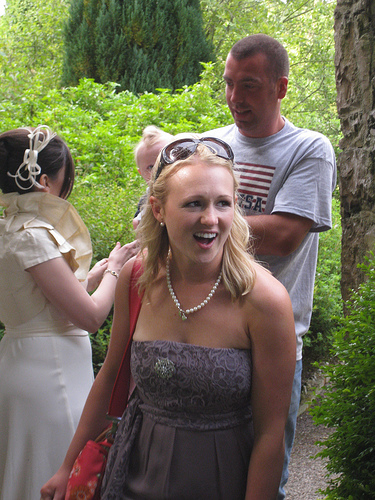

In [60]:
Image.open(img_name_val[rid])

(1, 8, 8, 2048)
Real Caption: <start> a woman in a dress with sunglasses resting on her head <end>
Predicted Caption With Beam Search: <start> a wedding couples are celebrating their wedding picture taken for a wedding photo taken in front of an event posing for the moment in the middle of an event posing for the moment in the middle of an event posing for the moment in the middle of an event posing for the moment in the middle of an event posing for the moment in the middle of an event posing for the moment in the middle of an event
Predicted Caption With Greedy Search: a man and woman are celebrating their wedding day <end>


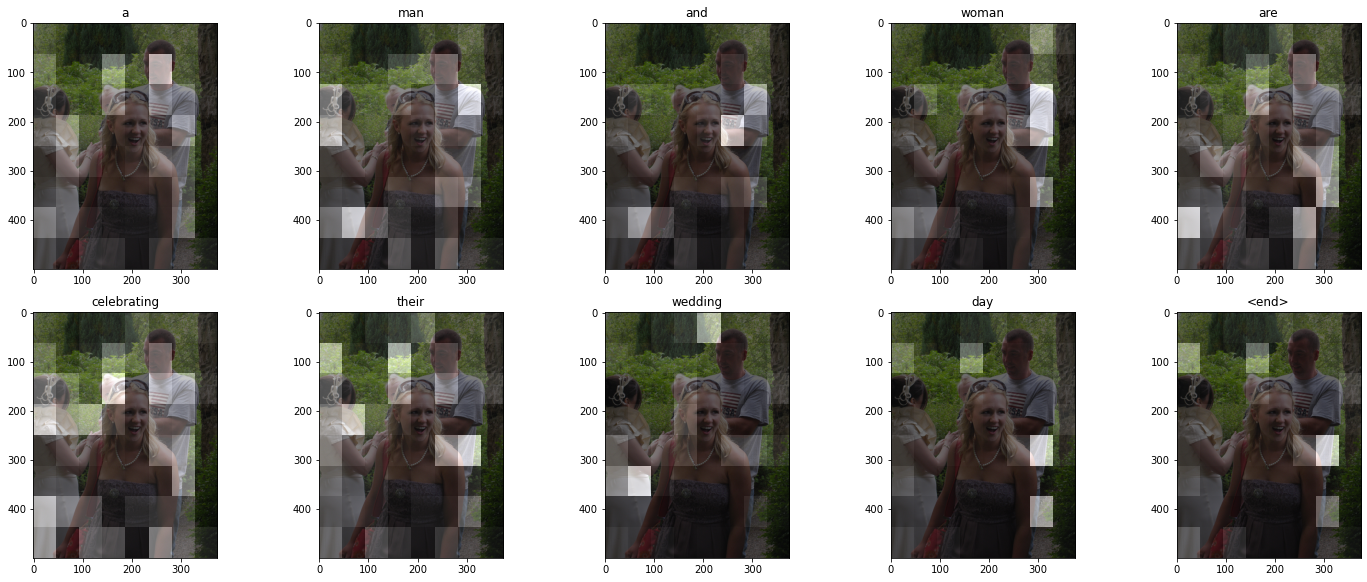

In [61]:
# get full path of the image indexed `rid`
image = img_name_val[rid]
real_caption = ' '.join((tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]))
beam_result = evaluate(image, 5)
greedy_result, attention_plot = evaluate_with_attention(image)

print('Real Caption:', real_caption)
print('Predicted Caption With Beam Search:', ' '.join(beam_result))
print('Predicted Caption With Greedy Search:', ' '.join(greedy_result))
plot_attention(image, greedy_result, attention_plot)